# **A2C Algorithm (pytorch)**


This notebook demonstrates how to implement the Advantage Actor-Critic (A2C) algorithm for the CartPole-v1 from OpenAI Gym environment using PyTorch.

1. **Visualize A2C Algorithm**: Visualization of the A2C algorithm's architecture using Graphviz.
2. **Imports and Helper Functions**: Essential libraries are imported, and helper functions are defined for tensor conversion, video rendering, and animation display.
3. **Network Definitions**: Neural network architectures for the Actor and Critic are defined.
4. **Memory Class**: A custom memory class to store experience samples.
5. **Environment and Initializatio**n: The environment is initialized, and Actor and Critic networks are set up.
6. **Training Function**: The train function updates the Actor and Critic networks based on stored experiences.
7. **Training Loop**: The main training loop where the agent interacts with the environment, collects experiences, and updates models. It also captures video frames of the training process.
8. **Save and Display Video**: Functions to save and display the recorded video of the training process in Google Colab.
9. **Plot Rewards**: Visualization of the total rewards per episode to analyze the training performance.
10. **Display Animation**: Display an animation of the training process using the collected video frames.






# Visualize A2C Algorithm

A2C Algorithm block diagram created successfully!


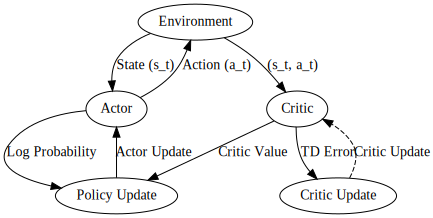

In [ ]:
# Visualize A2C Algorithm
import graphviz
graphviz.__version__, graphviz.version()
from graphviz import Digraph

# Define the graph
dot = Digraph(name='A2C_Algorithm', format='png')

# Add nodes
dot.node('environment', label='Environment')
dot.node('actor', label='Actor')
dot.node('critic', label='Critic')
dot.node('policy_update', label='Policy Update')
dot.node('critic_update', label='Critic Update')

# Add edges with labels
dot.edge('environment', 'actor', label='State (s_t)')
dot.edge('actor', 'environment', label='Action (a_t)')
dot.edge('environment', 'critic', label='(s_t, a_t)')
dot.edge('critic', 'policy_update', label='Critic Value')
dot.edge('actor', 'policy_update', label='Log Probability')
dot.edge('policy_update', 'actor', label='Actor Update')
dot.edge('critic', 'critic_update', label='TD Error')
dot.edge('critic_update', 'critic', label='Critic Update', style='dashed')

# Render the graph
dot.render('a2c_diagram.png', view=True)

print("A2C Algorithm block diagram created successfully!")

dot

The **A2C (Advantage Actor-Critic)** algorithm diagram visually represents the key components and data flow involved in the A2C reinforcement learning algorithm. Here’s a summary of the diagram's components and their interactions:

**Environment**: The environment interacts with the agent by providing states and rewards. It receives actions from the Actor and sends state-action pairs to the Critic.

**Actor**: The Actor network decides which action to take based on the current state. It receives the state from the environment and sends the chosen action back. The Actor also receives updates from the Policy Update step to improve its policy.

**Critic**: The Critic network estimates the value of states or state-action pairs. It receives state-action pairs from the environment and provides value estimates to the Policy Update step. The Critic is updated based on the TD (temporal difference) error.

**Policy Update**: This step updates the Actor based on the computed advantage function, which measures how good the taken actions are relative to the estimated values. The Policy Update step adjusts the Actor’s policy to maximize rewards.

**Critic Update**: This step refines the Critic’s value function based on the TD error, which is the difference between the predicted value and the actual reward plus the discounted value of the next state.

**Data Flow**:

The Environment sends the state to the Actor and receives actions from it.

The Actor provides actions to the Environment and logs probabilities of those actions.

The Environment provides state-action pairs to the Critic for value estimation.

The Critic calculates the TD error and provides value estimates to the Policy Update step.

The Policy Update step uses the advantage function and the Actor’s log probabilities to update the Actor.

The Critic is updated based on the TD error received from the Critic Update step.

The diagram encapsulates the iterative process of updating both the Actor and Critic networks to optimize the policy and value function for improved decision-making in reinforcement learning.

# Imports and Helper Function

In [ ]:
# General Summary
# This notebook demonstrates training a reinforcement learning agent using a policy gradient method on the CartPole-v1 environment from OpenAI's Gym.
# The notebook includes setup for neural network models, a memory class to store experience, training routines, and video recording of agent performance.

# Cell 1: Imports and Helper Functions
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import cv2
import matplotlib.animation as animation

# Helper function to convert numpy arrays to tensors
def t(x): return torch.tensor(x, dtype=torch.float32)

# Function to display animation in Google Colab
def display_animation(frames, interval=50):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval)
    return HTML(ani.to_jshtml())

# Network Definitions

In [ ]:
# Network Definitions
# This cell defines the Actor and Critic neural network modules for the reinforcement learning agent.

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, X):
        mean = self.model(X)
        std = torch.exp(self.log_std)
        return mean, std

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        return self.model(X)


# Memory Class

In [ ]:
# Memory Class
# This cell defines the Memory class used to store experience tuples (state, action, reward, etc.) during training.

class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.log_probs[:]
        del self.values[:]
        del self.rewards[:]
        del self.dones[:]

    def __len__(self):
        return len(self.rewards)

    def reversed(self):
        return reversed(list(zip(self.states, self.actions, self.log_probs, self.values, self.rewards, self.dones)))

# Environment and Initialization

In [ ]:
# Environment and Initialization
# This cell initializes the CartPole-v1 environment and sets up the Actor and Critic networks along with their optimizers.

env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n  # Discrete action space

# Initialize actor and critic
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)

gamma = 0.99
memory = Memory()
max_steps = 200
batch_size = 64
episode_rewards = []

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Training Function

In [ ]:
# Training Function
# This cell contains the function to train the Actor and Critic networks using the experiences stored in the memory.

def train(memory, q_vals):
    values = torch.stack(memory.values)
    q_vals = torch.tensor(q_vals, dtype=torch.float32)
    advantage = q_vals - values

    # Critic loss
    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()

    # Actor loss
    actor_loss = (-torch.stack(memory.log_probs) * advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

# Training Loop

In [ ]:
# Training Loop
# This cell runs the training loop for the reinforcement learning agent. It collects experience, trains the networks, and records video frames.

def run_training(episodes=1000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        video_frames = []

        while not done:
            state_tensor = t(state)
            mean, _ = actor(state_tensor)
            dist = torch.distributions.Categorical(logits=mean)
            action = dist.sample()

            next_state, reward, done, _ = env.step(action.item())
            total_reward += reward
            steps += 1
            memory.add(state_tensor, action, dist.log_prob(action), critic(state_tensor), reward, done)

            video_frames.append(env.render(mode='rgb_array'))

            if done or (steps % max_steps == 0):
                if len(memory) >= batch_size:
                    last_value = critic(t(next_state)).detach()
                    q_vals = np.zeros(len(memory))

                    for i, (_, _, _, _, reward, done) in enumerate(memory.reversed()):
                        last_value = reward + gamma * last_value * (1.0 - done)
                        q_vals[len(memory) - 1 - i] = last_value

                    train(memory, q_vals)
                    memory.clear()

        episode_rewards.append(total_reward)

        if episode == episodes - 1:
            return video_frames

# Run the training
video_frames = run_training()

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


# Recording and Displaying the Video

In [ ]:
# Save and Display Video
# This cell saves the recorded video of the agent's performance and displays it with a replay button.

def save_video(frames, filename, fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    video.release()

def display_video_with_replay(filename):
    video_html = f"""
    <video id="videoPlayer" width="600" controls>
        <source src="{filename}" type="video/mp4">
    </video>
    <br>
    <button onclick="document.getElementById('videoPlayer').currentTime=0;">Replay Video</button>
    """
    display(HTML(video_html))

# Save the video
save_video(video_frames, '/content/sac_cartpole.mp4')

# Display the video with a replay button
display_video_with_replay('/content/sac_cartpole.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot Rewards

In [ ]:
# Plot Rewards
# This cell plots the total rewards per episode to visualize the training progress.

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Total Reward')
plt.title("Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# Display Animation


In [ ]:
display(display_animation(video_frames))